# Объединение признаков из разных датасетов

In [7]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'


from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.tree import DecisionTreeClassifier

import xgboost as xgb

pd.set_option('display.max_rows', 100)

In [4]:
class BaseModel(object):
    """Aim of this class is to provide fast calculation
    of results and metrics that are needed for each model
    """

    def __init__(self, X, y, cv='loo', random_state=42, *args, **kwargs):
        self.y_pred = np.zeros(shape=y.shape)
        self.y_true = y
        self.random_state=random_state
        self.cv = cv
        if cv == 'loo':
            self.cv = LeaveOneOut()
        elif cv == '5fold':
            # self.cv = StratifiedKFold(n_splits=5)
            self.cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        elif cv == '10fold':
            # self.cv = StratifiedKFold(n_splits=10)
            self.cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
        else:
            raise ValueError('wrong value of the cv parameter')
        self._run(X, y, *args, **kwargs)

    def _run(self, X, y, *args, **kwargs):
        """Need to be redefined"""
        raise NotImplementedError

    def get_roc_auc(self):
        return roc_auc_score(self.y_true, self.y_pred)

    def get_accuracy(self):
        return accuracy_score(self.y_true, self.y_pred > 0.5)

    def get_outliers_idx(self, n_outliers=5):
        outliers_idx = (
            np.argsort(
                np.abs(self.y_pred - self.y_true))
            [::-1]
            [:n_outliers])
        return outliers_idx

    def get_ypred_df(self):
        df = pd.DataFrame({'y_true': self.y_true, 'y_pred': self.y_pred})
        return df


class LinearModel(BaseModel):

    def _run(self, X, y, *args, **kwargs):

        X = StandardScaler().fit_transform(X)

        for train_idx, test_idx in self.cv.split(X, y):
            model = LogisticRegression(solver='liblinear')
            model.fit(X[train_idx, :], y[train_idx])
            self.y_pred[test_idx] = model.predict_proba(X[test_idx, :])[:, 1]
    
class LinearModelNoOutliers(BaseModel):

    def _run(self, X, y, to_drop=[], *args, **kwargs):
        
        X = StandardScaler().fit_transform(X)

        for train_idx, test_idx in self.cv.split(X, y):
            train_idx = [idx for idx in train_idx if idx not in to_drop]
            model = LogisticRegression(solver='liblinear')
            model.fit(X[train_idx, :], y[train_idx])
            self.y_pred[test_idx] = model.predict_proba(X[test_idx, :])[:, 1]

In [19]:
def run_exper(X, y):
    if type(y) == type(pd.Series()):
        y = y.values

    roc_aucs = []
    accs = []
    for _ in range(100):
        random_state = np.random.choice(np.arange(1000))
        model_1 = LinearModel(X, y, cv='10fold', random_state=random_state)
        model_2 = LinearModelNoOutliers(X, y, cv='10fold', random_state=random_state, 
                                      to_drop=model_1.get_outliers_idx(n_outliers=10))

        roc_auc = model_2.get_roc_auc()
        acc = model_2.get_accuracy()
        roc_aucs.append(roc_auc)
        accs.append(acc)
    roc_aucs = np.array(roc_aucs)
    accs = np.array(accs)
    return {
        'roc_auc_mean': roc_aucs.mean(),
        'roc_auc_std': roc_aucs.std(),
        'acc_mean': accs.mean(),
        'acc_std': accs.std()
    }

In [29]:
def remove_features(df, best_score, features):
    np.random.shuffle(features)
    features_copy = features.copy()
    for feat in features_copy:
        new_features = [f for f in features if f != feat]
        new_X = df[new_features]
        score = run_exper(new_X.fillna(0), df['is_patient'])['roc_auc_mean']
        if score > best_score + 0.001:
            print('Excluded ', feat, '. New best score = {:.3f}'.format(score))         
            features = new_features
            best_score = score
    return features


In [27]:
df_env_alpha = pd.read_csv('../own_data/1905_features/env_alpha_ep3.csv')
df_env_beta = pd.read_csv('../own_data/1905_features/env_beta_ep3.csv')
df_coh_alpha = pd.read_csv('../own_data/1905_features/coh_alpha_ep3.csv')
df_coh_beta = pd.read_csv('../own_data/1905_features/coh_beta_ep3.csv')

In [46]:
df_env_alpha.columns = [col.replace('env_cor', 'env_alpha') for col in df_env_alpha.columns]
df_env_beta.columns = [col.replace('env_cor', 'env_beta') for col in df_env_beta.columns]
df_coh_alpha.columns = [col.replace('con_alpha', 'coh_alpha') for col in df_coh_alpha.columns]
df_coh_beta.columns = [col.replace('con_alpha', 'coh_beta') for col in df_coh_beta.columns]

In [67]:
features_env_alpha = [col for col in df_env_alpha.columns if col not in ['dataset', 'is_patient', 'fn']]

In [68]:
res = run_exper(df_env_alpha[features_env_alpha], df_env_alpha['is_patient'].values)
res

{'roc_auc_mean': 0.8202121212121211,
 'roc_auc_std': 0.015749638638169947,
 'acc_mean': 0.7353932584269662,
 'acc_std': 0.02844161810976886}

In [69]:
features_env_alpha_filt = remove_features(df_env_alpha, res['roc_auc_mean'], features_env_alpha)

Excluded  env_alpha_T4_O2 . New best score = 0.824
Excluded  env_alpha_O2_C3 . New best score = 0.825
Excluded  env_alpha_T4_P4 . New best score = 0.828
Excluded  env_alpha_T4_C3 . New best score = 0.832
Excluded  env_alpha_P4_C4 . New best score = 0.834
Excluded  env_alpha_F8_F4 . New best score = 0.836
Excluded  env_alpha_F7_O2 . New best score = 0.837
Excluded  env_alpha_T6_C3 . New best score = 0.841
Excluded  env_alpha_T6_O2 . New best score = 0.842
Excluded  env_alpha_F7_C3 . New best score = 0.844
Excluded  env_alpha_T3_P3 . New best score = 0.846


In [70]:
print('N features before = {}, after = {}'.format(len(features_env_alpha), len(features_env_alpha_filt)))

N features before = 91, after = 80


In [52]:
features_env_beta = [col for col in df_env_beta.columns if col not in ['dataset', 'is_patient', 'fn']]

In [53]:
res = run_exper(df_env_beta[features_env_beta], df_env_beta['is_patient'])
res

{'roc_auc_mean': 0.7441262626262629,
 'roc_auc_std': 0.016919215287184226,
 'acc_mean': 0.6779775280898878,
 'acc_std': 0.023899592177466355}

In [54]:
features_env_beta_filt = remove_features(df_env_beta, res['roc_auc_mean'], features_env_beta)

Excluded  env_beta_T4_F3 . New best score = 0.746
Excluded  env_beta_T3_P3 . New best score = 0.747
Excluded  env_beta_C4_F7 . New best score = 0.749
Excluded  env_beta_C4_T3 . New best score = 0.753
Excluded  env_beta_F8_F4 . New best score = 0.756
Excluded  env_beta_O1_F3 . New best score = 0.759
Excluded  env_beta_P4_F7 . New best score = 0.760
Excluded  env_beta_F3_O2 . New best score = 0.761
Excluded  env_beta_F3_C3 . New best score = 0.764
Excluded  env_beta_T4_O1 . New best score = 0.766
Excluded  env_beta_F7_F4 . New best score = 0.769
Excluded  env_beta_T6_O2 . New best score = 0.772
Excluded  env_beta_C3_T5 . New best score = 0.773
Excluded  env_beta_O2_P3 . New best score = 0.777
Excluded  env_beta_T6_F7 . New best score = 0.779
Excluded  env_beta_C4_F4 . New best score = 0.781
Excluded  env_beta_T6_O1 . New best score = 0.782
Excluded  env_beta_T6_P4 . New best score = 0.787
Excluded  env_beta_P3_T5 . New best score = 0.788
Excluded  env_beta_O1_F8 . New best score = 0.792


In [55]:
print('N features before = {}, after = {}'.format(len(features_env_beta), len(features_env_beta_filt)))

N features before = 91, after = 69


In [56]:
features_coh_alpha = [col for col in df_coh_alpha.columns if col not in ['dataset', 'is_patient', 'fn']]

In [57]:
res = run_exper(df_coh_alpha[features_coh_alpha].fillna(0), df_coh_alpha['is_patient'])
res

{'roc_auc_mean': 0.797429292929293,
 'roc_auc_std': 0.01531412655676825,
 'acc_mean': 0.7408988764044945,
 'acc_std': 0.023878453315929294}

In [58]:
features_coh_alpha_filt = remove_features(df_coh_alpha, res['roc_auc_mean'], features_coh_alpha)

Excluded  coh_alpha_P4_C3 . New best score = 0.799
Excluded  coh_alpha_O1_P3 . New best score = 0.804
Excluded  coh_alpha_T4_C4 . New best score = 0.807
Excluded  coh_alpha_C4_C3 . New best score = 0.809
Excluded  coh_alpha_T3_P3 . New best score = 0.812
Excluded  coh_alpha_F3_P3 . New best score = 0.816
Excluded  coh_alpha_P4_T3 . New best score = 0.817
Excluded  coh_alpha_F3_C3 . New best score = 0.819
Excluded  coh_alpha_F3_O2 . New best score = 0.820
Excluded  coh_alpha_T4_P3 . New best score = 0.823
Excluded  coh_alpha_O1_F4 . New best score = 0.826
Excluded  coh_alpha_F7_F3 . New best score = 0.833


In [59]:
print('N features before = {}, after = {}'.format(len(features_coh_alpha), len(features_coh_alpha_filt)))

N features before = 91, after = 79


In [60]:
features_coh_beta = [col for col in df_coh_beta.columns if col not in ['dataset', 'is_patient', 'fn']]

In [61]:
res = run_exper(df_coh_beta[features_coh_beta].fillna(0), df_coh_beta['is_patient'])
res

{'roc_auc_mean': 0.8189191919191918,
 'roc_auc_std': 0.015553984572383734,
 'acc_mean': 0.7557303370786517,
 'acc_std': 0.023224477203395537}

In [62]:
features_coh_beta_filt = remove_features(df_coh_beta, res['roc_auc_mean'], features_coh_beta)

Excluded  coh_beta_F3_O2 . New best score = 0.822
Excluded  coh_beta_F7_C3 . New best score = 0.823
Excluded  coh_beta_T4_O2 . New best score = 0.826
Excluded  coh_beta_P3_T5 . New best score = 0.828
Excluded  coh_beta_F7_O2 . New best score = 0.829
Excluded  coh_beta_F3_C3 . New best score = 0.832
Excluded  coh_beta_C4_O2 . New best score = 0.834
Excluded  coh_beta_C4_T3 . New best score = 0.835
Excluded  coh_beta_F8_T3 . New best score = 0.836


In [63]:
print('N features before = {}, after = {}'.format(len(features_coh_beta), len(features_coh_beta_filt)))

N features before = 91, after = 82


Используем все датасеты

In [71]:
df_merged = (
    df_env_alpha[features_env_alpha_filt + ['dataset', 'is_patient', 'fn']]
    .merge(df_env_beta[features_env_beta_filt + ['fn']], on='fn')
    .merge(df_coh_alpha[features_coh_alpha_filt + ['fn']], on='fn')
    .merge(df_coh_beta[features_coh_beta_filt + ['fn']], on='fn')
)

In [72]:
all_feats = features_env_alpha_filt + features_env_beta_filt + features_coh_alpha_filt + features_coh_beta_filt

In [73]:
run_exper(df_merged[all_feats].fillna(0), df_merged['is_patient'])

{'roc_auc_mean': 0.8575606060606061,
 'roc_auc_std': 0.012317529521660906,
 'acc_mean': 0.7723595505617976,
 'acc_std': 0.02087711806813755}

Используем два лучших датасета

In [74]:
df_merged = (
    df_env_alpha[features_env_alpha_filt + ['dataset', 'is_patient', 'fn']]
#     .merge(df_env_beta[features_env_beta_filt + ['fn']], on='fn')
#     .merge(df_coh_alpha[features_coh_alpha_filt + ['fn']], on='fn')
    .merge(df_coh_beta[features_coh_beta_filt + ['fn']], on='fn')
)

In [75]:
all_feats = features_env_alpha_filt + features_coh_beta_filt

In [76]:
run_exper(df_merged[all_feats].fillna(0), df_merged['is_patient'])

{'roc_auc_mean': 0.8804898989898988,
 'roc_auc_std': 0.008880464040081849,
 'acc_mean': 0.7974157303370785,
 'acc_std': 0.021167477728097978}

In [79]:
import shap

In [85]:
model = LogisticRegression(solver='liblinear')

In [87]:
model.fit(df_merged[all_feats].fillna(0), df_merged['is_patient'].values)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [94]:
X = StandardScaler().fit_transform(df_merged[all_feats].fillna(0))

In [95]:
explainer = shap.LinearExplainer(model, X, feature_dependence="independent")

In [96]:
shap_values = explainer.shap_values(X)

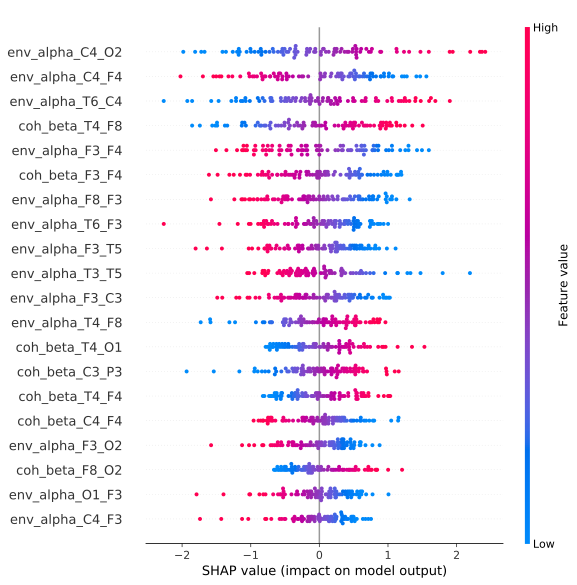

In [107]:
shap.summary_plot(shap_values, X, feature_names=all_feats, show=False)
plt.savefig('shap_results.png', dpi=200, bbox_inches='tight')

In [92]:
features_env_alpha_filt

['env_alpha_C4_T5',
 'env_alpha_F7_P3',
 'env_alpha_O1_P3',
 'env_alpha_P4_O2',
 'env_alpha_C4_P3',
 'env_alpha_T6_T5',
 'env_alpha_T4_T3',
 'env_alpha_O1_C4',
 'env_alpha_O1_F4',
 'env_alpha_P4_F4',
 'env_alpha_F8_F7',
 'env_alpha_F7_F3',
 'env_alpha_T6_P4',
 'env_alpha_C4_F7',
 'env_alpha_F7_T5',
 'env_alpha_O1_F7',
 'env_alpha_T6_F4',
 'env_alpha_T3_F3',
 'env_alpha_T4_O1',
 'env_alpha_O1_O2',
 'env_alpha_O1_F8',
 'env_alpha_T3_T5',
 'env_alpha_C3_T5',
 'env_alpha_O1_C3',
 'env_alpha_T3_F7',
 'env_alpha_P4_F3',
 'env_alpha_T4_F7',
 'env_alpha_T6_C4',
 'env_alpha_P4_P3',
 'env_alpha_F8_T3',
 'env_alpha_T6_F3',
 'env_alpha_F4_T5',
 'env_alpha_T4_T5',
 'env_alpha_O1_T5',
 'env_alpha_C4_F4',
 'env_alpha_C4_C3',
 'env_alpha_T6_T4',
 'env_alpha_C4_T3',
 'env_alpha_P4_T3',
 'env_alpha_F3_C3',
 'env_alpha_F8_C3',
 'env_alpha_F8_T5',
 'env_alpha_T6_P3',
 'env_alpha_T3_F4',
 'env_alpha_T4_C4',
 'env_alpha_F3_F4',
 'env_alpha_F8_P4',
 'env_alpha_P4_C3',
 'env_alpha_O2_F4',
 'env_alpha_P3_T5',
 'env_alpha_T6_F7',
 'env_alpha_T6_T3',
 'env_alpha_P4_T5',
 'env_alpha_F8_C4',
 'env_alpha_F3_T5',
 'env_alpha_T3_C3',
 'env_alpha_T4_P3',
 'env_alpha_T3_O2',
 'env_alpha_F3_O2',
 'env_alpha_P4_F7',
 'env_alpha_O1_P4',
 'env_alpha_T4_F4',
 'env_alpha_T6_O1',
 'env_alpha_T4_F8',
 'env_alpha_T6_F8',
 'env_alpha_F8_O2',
 'env_alpha_O1_F3',
 'env_alpha_O1_T3',
 'env_alpha_O2_P3',
 'env_alpha_O2_T5',
 'env_alpha_F8_F3',
 'env_alpha_F4_P3',
 'env_alpha_F4_C3',
 'env_alpha_F3_P3',
 'env_alpha_F7_F4',
 'env_alpha_C3_P3',
 'env_alpha_F8_P3',
 'env_alpha_C4_O2',
 'env_alpha_T4_F3',
 'env_alpha_C4_F3']

In [93]:
features_coh_beta_filt

['coh_beta_T6_T3',
 'coh_beta_T6_T5',
 'coh_beta_T6_P4',
 'coh_beta_C4_F4',
 'coh_beta_T4_F4',
 'coh_beta_P4_O2',
 'coh_beta_F8_F4',
 'coh_beta_T4_F8',
 'coh_beta_F7_F3',
 'coh_beta_T6_P3',
 'coh_beta_T6_T4',
 'coh_beta_O1_F8',
 'coh_beta_F4_P3',
 'coh_beta_F8_O2',
 'coh_beta_O1_P4',
 'coh_beta_O1_O2',
 'coh_beta_P4_F7',
 'coh_beta_O1_T5',
 'coh_beta_C4_T5',
 'coh_beta_T4_O1',
 'coh_beta_F8_C4',
 'coh_beta_T3_C3',
 'coh_beta_F4_T5',
 'coh_beta_T3_O2',
 'coh_beta_T6_O2',
 'coh_beta_F4_C3',
 'coh_beta_C4_F3',
 'coh_beta_T6_O1',
 'coh_beta_C3_T5',
 'coh_beta_P4_C3',
 'coh_beta_F3_F4',
 'coh_beta_C4_F7',
 'coh_beta_O1_C3',
 'coh_beta_T4_F3',
 'coh_beta_F7_P3',
 'coh_beta_P4_F4',
 'coh_beta_C4_C3',
 'coh_beta_T3_F3',
 'coh_beta_F8_T5',
 'coh_beta_T3_P3',
 'coh_beta_T6_F7',
 'coh_beta_O1_T3',
 'coh_beta_O1_F3',
 'coh_beta_F8_F3',
 'coh_beta_T4_P3',
 'coh_beta_T6_F3',
 'coh_beta_F3_T5',
 'coh_beta_P4_C4',
 'coh_beta_F8_C3',
 'coh_beta_F8_P3',
 'coh_beta_T4_C3',
 'coh_beta_P4_T5',
 'coh_beta_T4_F7',
 'coh_beta_P4_P3',
 'coh_beta_T4_T3',
 'coh_beta_F7_F4',
 'coh_beta_T6_F4',
 'coh_beta_T3_F7',
 'coh_beta_F3_P3',
 'coh_beta_F8_P4',
 'coh_beta_F8_F7',
 'coh_beta_P4_T3',
 'coh_beta_T6_C4',
 'coh_beta_T6_F8',
 'coh_beta_O1_F4',
 'coh_beta_O2_C3',
 'coh_beta_T4_T5',
 'coh_beta_C4_P3',
 'coh_beta_T3_T5',
 'coh_beta_C3_P3',
 'coh_beta_F7_T5',
 'coh_beta_O2_P3',
 'coh_beta_O1_F7',
 'coh_beta_T6_C3',
 'coh_beta_T4_P4',
 'coh_beta_T3_F4',
 'coh_beta_O2_F4',
 'coh_beta_P4_F3',
 'coh_beta_O2_T5',
 'coh_beta_O1_P3',
 'coh_beta_O1_C4',
 'coh_beta_T4_C4']